# Klasyfikacja Liniowa
Łukasz Klimkiewicz, 244822

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Numer indeksu
index = 244822

In [ ]:
# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


## Implementacja klasyfikacji

In [55]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator

class CustomRidgeClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, alpha=1.0, fit_intercept=True):
        self.alpha = alpha
        self.fit_intercept = True
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        y = y.reshape(-1, 1)

        if self.fit_intercept:
            X = np.hstack([X, np.ones((X.shape[0], 1))])

        # Core logic
        d = X.shape[1]
        A = self.alpha*np.identity(d)
        theta = np.linalg.inv(X.T.dot(X)+A).dot(X.T).dot(y)

        if self.fit_intercept:
            self.coefficients = theta[:-1, 0]
            self.intercept = theta[-1, 0]
        else:
            self.coefficients = theta

        self.classes_ = np.array([0, 1])

        return self

    def decision_function(self, X):
        theta = self.coefficients
        result = X@theta
        if self.fit_intercept:
            result += self.intercept
        return np.column_stack([result])

    def predict(self, X):
        return self.decision_function(X) > 0.5

## Ocena 3

### Pierwszy zbiór

#### Generowanie danych

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generowanie
syn1_x, syn1_y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=1, random_state=index)

# Podział na zbiory
syn1_train_x, syn1_test_x, syn1_train_y, syn1_test_y = train_test_split(syn1_x, syn1_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn1_data = {
    'train': {
        'x': syn1_train_x,
        'y': syn1_train_y
    },
    'test': {
        'x': syn1_test_x,
        'y': syn1_test_y
    }
}

#### Wizualizacja danych

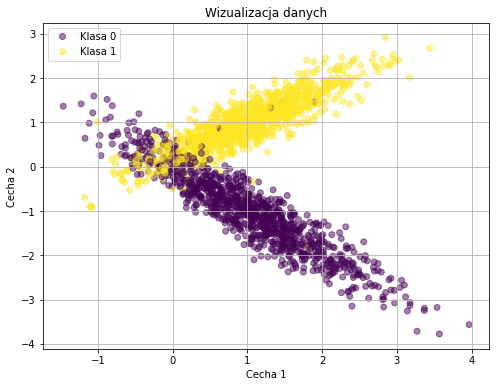

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(syn1_data['train']['x'][:,0], syn1_data['train']['x'][:,1], c=syn1_data['train']['y'], alpha=0.5)
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
ax.grid()
ax.set_title('Wizualizacja danych');

#### Nauka

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

custom_model_syn1 = make_pipeline(
    MinMaxScaler(),
    CustomRidgeClassifier(alpha=1)
)

scikit_model_syn1 = make_pipeline(
    MinMaxScaler(), 
    RidgeClassifier(alpha=1)
)

custom_model_syn1.fit(syn1_data['train']['x'], syn1_data['train']['y'])

scikit_model_syn1.fit(syn1_data['train']['x'], syn1_data['train']['y']);

#### Wizualizacja powierzchni decyzyjnej

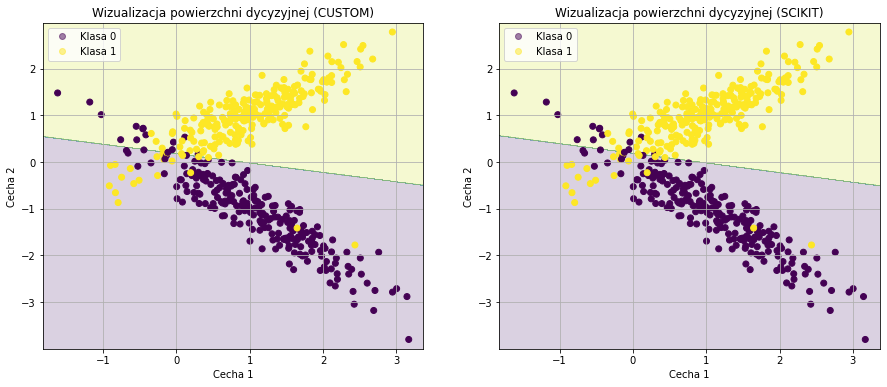

In [ ]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn1_data['test']

margin = 0.2
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn1, 'custom', axs[0]),
    (scikit_model_syn1, 'scikit', axs[1])
):
    space_syn1 = np.meshgrid(np.linspace(x1, x2, 1000), np.linspace(y1, y2, 1000))
    predictions_syn1 = model.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(1000, 1000)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

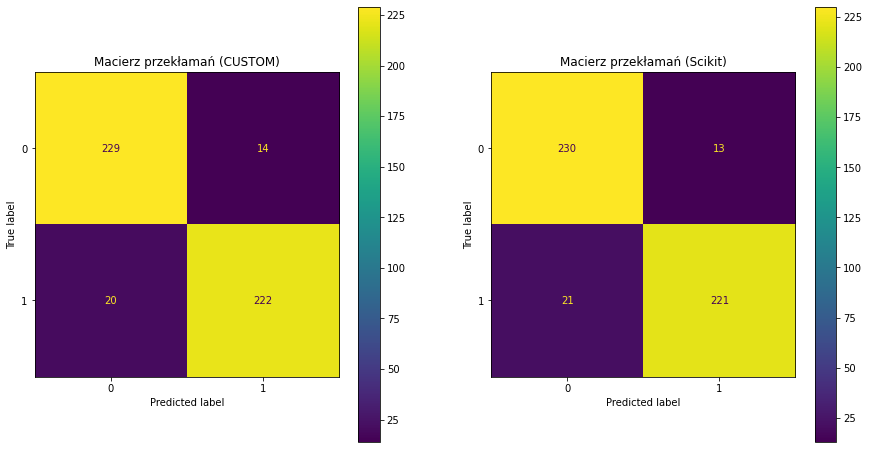

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn1, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn1, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (CUSTOM)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [ ]:
from sklearn.metrics import recall_score

# Obliczanie metryk
data = syn1_data['test']

sens_list = []
spec_list = []

for model in [custom_model_syn1, scikit_model_syn1]:
    
    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)

    sens_list.append(sens)
    spec_list.append(spec)
    
# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity
Custom,0.917355,0.942387
Scikit,0.913223,0.946502


#### Krzywa ROC

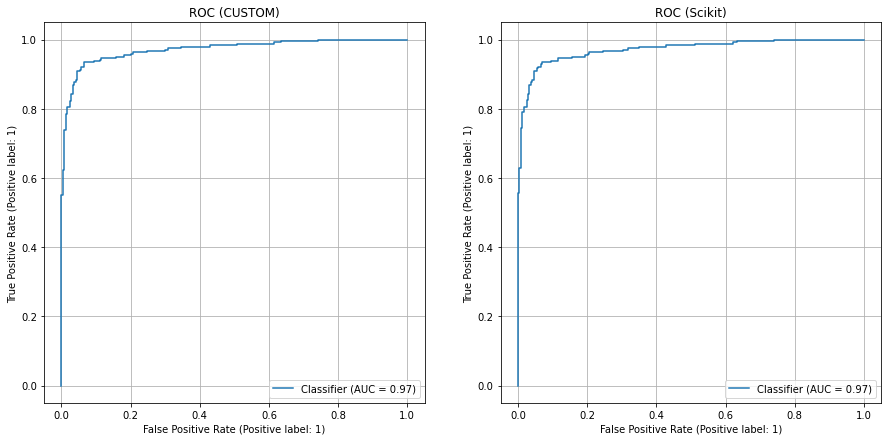

In [ ]:
from sklearn.metrics import RocCurveDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn1.decision_function(data['x'])
predictions_s = scikit_model_syn1.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)')

ax_c.grid()
ax_s.grid()

#### Czasy

In [ ]:
# Pomiar czasów
from sklearn.linear_model import RidgeClassifier
import timeit

custom_model_time = RidgeClassifier(alpha=1)
scikit_model_time = CustomRidgeClassifier(alpha=1)

def time_custom_fit():
    custom_model_time.fit(syn1_data['train']['x'], syn1_data['train']['y'])

def time_custom_predict():
    custom_model_time.predict(syn1_data['test']['x'])

def time_scikit_fit():
    scikit_model_time.fit(syn1_data['train']['x'], syn1_data['train']['y'])

def time_scikit_predict():
    scikit_model_time.predict(syn1_data['test']['x'])


time_cf = timeit.timeit(time_custom_fit, number=1000) / 1000
time_cp = timeit.timeit(time_custom_predict, number=1000) / 1000
time_sf = timeit.timeit(time_scikit_fit, number=1000) / 1000
time_sp = timeit.timeit(time_scikit_predict, number=1000) / 1000

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,0.001054,0.000049
Scikit,0.000070,0.000008


### Drugi zbiór

#### Generowanie danych

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generowanie
syn2_x, syn2_y = make_moons(n_samples=n_samples, random_state=seed)

# Podział na zbiory
syn2_train_x, syn2_test_x, syn2_train_y, syn2_test_y = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn2_data = {
    'train': {
        'x': syn2_train_x,
        'y': syn2_train_y,
    },
    'test': {
        'x': syn2_test_x,
        'y': syn2_test_y,
    }
}

#### Wizualizacja danych

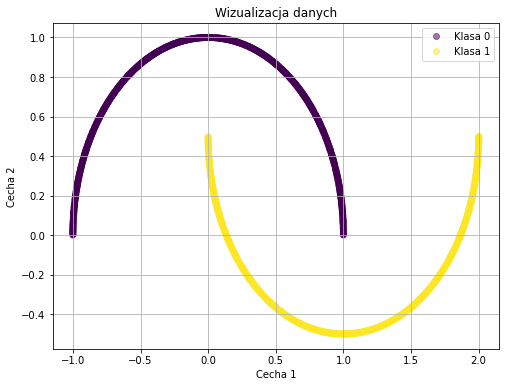

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(syn2_data['train']['x'][:,0], syn2_data['train']['x'][:,1], c=syn2_data['train']['y'], alpha=0.5)
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
ax.grid()
ax.set_title('Wizualizacja danych');

#### Nauka

In [56]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

custom_model_syn2 = make_pipeline(
    MinMaxScaler(), 
    PolynomialFeatures(degree=3, include_bias=False),
    CustomRidgeClassifier(alpha=1e-2)
)

scikit_model_syn2 = make_pipeline(
    MinMaxScaler(), 
    PolynomialFeatures(degree=3, include_bias=False),
    RidgeClassifier(alpha=1e-2)
)

custom_model_syn2.fit(syn2_data['train']['x'], syn2_data['train']['y'])

scikit_model_syn2.fit(syn2_data['train']['x'], syn2_data['train']['y']);

#### Wizualizacja powierzchni decyzyjnej

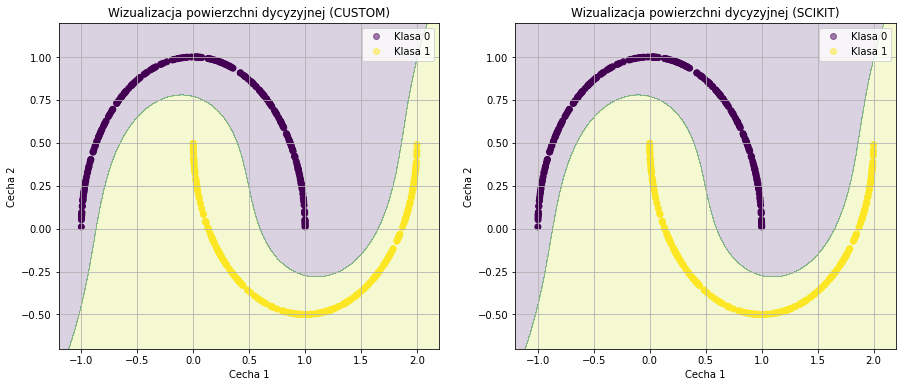

In [57]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn2_data['test']

margin = 0.2
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn2, 'custom', axs[0]),
    (scikit_model_syn2, 'scikit', axs[1])
):
    space_syn2 = np.meshgrid(np.linspace(x1, x2, 1000), np.linspace(y1, y2, 1000))
    predictions_syn2 = model.predict(np.dstack([*space_syn2]).reshape(-1, 2)).reshape(1000, 1000)

    ax.contourf(space_syn2[0], space_syn2[1], predictions_syn2, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

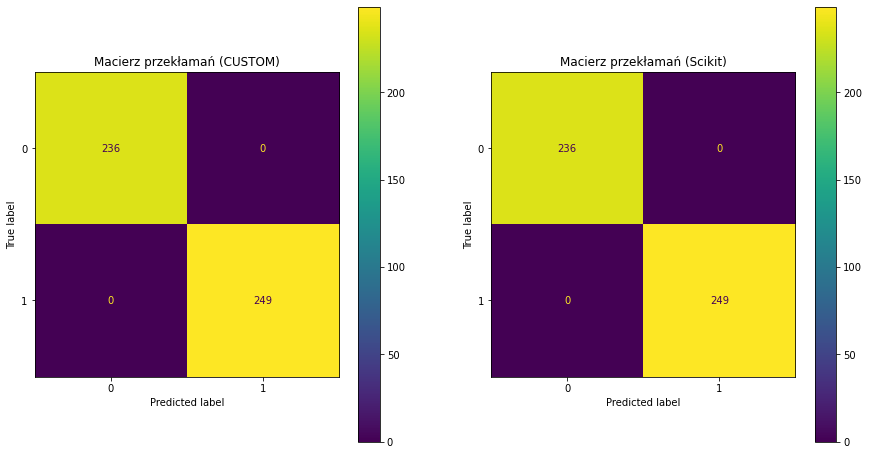

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn2_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn2, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn2, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (CUSTOM)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [ ]:
from sklearn.metrics import recall_score

# Obliczanie metryk
data = syn2_data['test']

sens_list = []
spec_list = []

for model in [custom_model_syn2, scikit_model_syn2]:
    
    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)

    sens_list.append(sens)
    spec_list.append(spec)
    
# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity
Custom,1.0,1.0
Scikit,1.0,1.0


#### Krzywa ROC

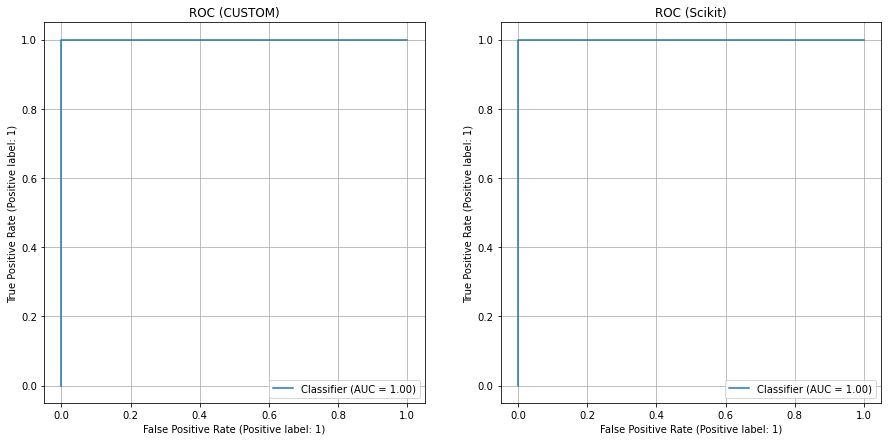

In [ ]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = syn2_data['train']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn2.decision_function(data['x'])
predictions_s = scikit_model_syn2.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

#### Czasy

In [ ]:
# Pomiar czasów
from sklearn.linear_model import RidgeClassifier
import timeit

custom_model_time = RidgeClassifier()
scikit_model_time = CustomRidgeClassifier(alpha=0.3)

def time_custom_fit():
    custom_model_time.fit(syn2_data['train']['x'], syn2_data['train']['y'])

def time_custom_predict():
    custom_model_time.predict(syn2_data['test']['x'])

def time_scikit_fit():
    scikit_model_time.fit(syn2_data['train']['x'], syn2_data['train']['y'])

def time_scikit_predict():
    scikit_model_time.predict(syn2_data['test']['x'])


time_cf = timeit.timeit(time_custom_fit, number=1000) / 1000
time_cp = timeit.timeit(time_custom_predict, number=1000) / 1000
time_sf = timeit.timeit(time_scikit_fit, number=1000) / 1000
time_sp = timeit.timeit(time_scikit_predict, number=1000) / 1000

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,0.001122,0.000050
Scikit,0.000069,0.000008


## Ocena 4

#### Wczytywanie danych

In [ ]:
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fps', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

heart_data = pd.read_csv('HeartCleveland.csv', names=column_names, na_values=['?'])
heart_data.head()

,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
heart_data.describe()

,age,sex,cp,trestbps,chol,fps,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Objaśnienie kolumn:
```
age - age in years
sex - sex (1 = male; 0 = female)
cp - chest pain type
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic
trestbps -resting blood pressure (in mm Hg on admission to the hospital)
chol - serum cholestoral in mg/dl
fbs -(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
restecg -resting electrocardiographic results
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach - maximum heart rate achieved
exang - exercise induced angina (1 = yes; 0 = no)
oldpeak - ST depression induced by exercise relative to rest
slope - the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping
ca - number of major vessels (0-3) colored by flourosopy
thal- 3 = normal; 6 = fixed defect; 7 = reversable defect
num - diagnosis of heart disease (angiographic disease status)
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing
```

#### Brakujące wartości

In [ ]:
# Liczba brakujących wartości
heart_data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fps         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [ ]:
# Usuwanie brakujących wartości
heart_data.dropna(inplace=True)

#### Zastąpienie zmiennej przewidywanej wartością binarną

In [ ]:
heart_data.num.clip(upper=1, inplace=True)

#### Wartości statystyczne - cechy ciągłe

In [ ]:
continuous_vars = ['trestbps', 'chol', 'thalach', 'oldpeak']
heart_data[continuous_vars].describe(percentiles=[])[1:]

,trestbps,chol,thalach,oldpeak
mean,131.693603,247.350168,149.599327,1.055556
std,17.762806,51.997583,22.941562,1.166123
min,94.000000,126.000000,71.000000,0.000000
50%,130.000000,243.000000,153.000000,0.800000
max,200.000000,564.000000,202.000000,6.200000


#### Wartości statystyczne - cechy dyskretne

In [ ]:
discrete_vars = ['age', 'ca']
heart_data[discrete_vars].describe(percentiles=[])[1:]

,age,ca
mean,54.542088,0.676768
std,9.049736,0.938965
min,29.000000,0.000000
50%,56.000000,0.000000
max,77.000000,3.000000


In [ ]:
heart_data[discrete_vars].mode()

,age,ca
0,58.0,0.0


#### Wartości statystyczne - cechy kategorialne

In [ ]:
categorical_vars = ['sex', 'cp', 'fps', 'restecg', 'exang', 'slope', 'thal']
df = heart_data[categorical_vars].describe(percentiles=[]).loc[['min', 'max']]
df = df.append(heart_data[categorical_vars].nunique().rename('distinct values')).astype(np.int32)
df

,sex,cp,fps,restecg,exang,slope,thal
min,0,1,0,0,0,1,3
max,1,4,1,2,1,3,7
distinct values,2,4,2,3,2,3,3


In [ ]:
heart_data[categorical_vars].mode().astype(np.int32)

,sex,cp,fps,restecg,exang,slope,thal
0,1,4,0,0,0,1,3


#### Histogramy cech

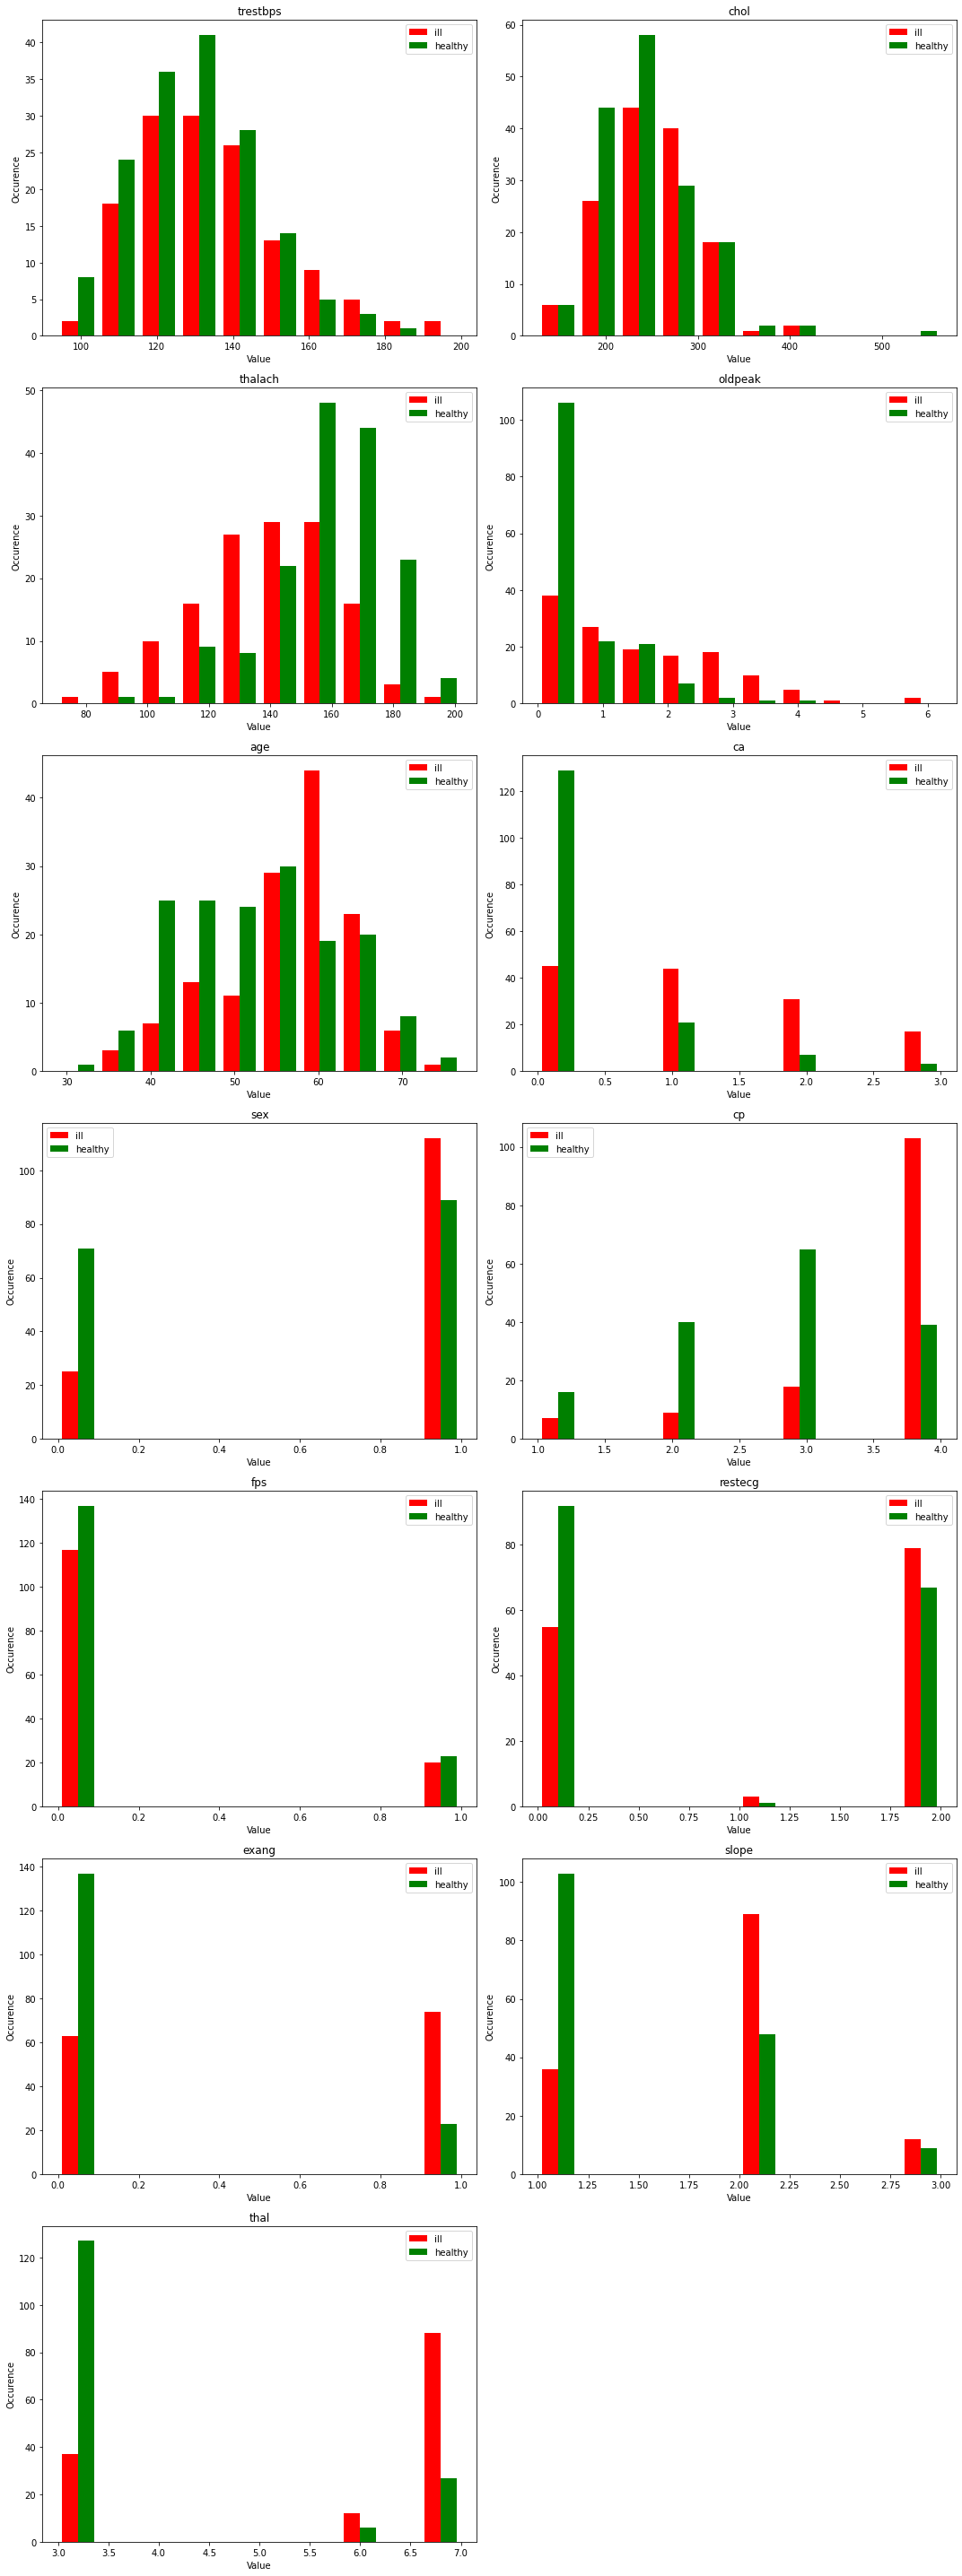

In [ ]:
fig, axs = plt.subplots(7, 2, figsize=(15, 40))
fig.delaxes(axs[6, 1])

bins_count = 10
columns = continuous_vars + discrete_vars + categorical_vars

positive_data = heart_data[heart_data.num == 1]
negative_data = heart_data[heart_data.num == 0]

for i, column in enumerate(columns):
    ax = axs[i//2][i%2]
    ax.hist([positive_data[column], negative_data[column]], bins=bins_count, color=['r', 'g'], label=['ill', 'healthy'])
    
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Occurence')
    ax.legend()
    
fig.tight_layout()

#### Macierz korelacji

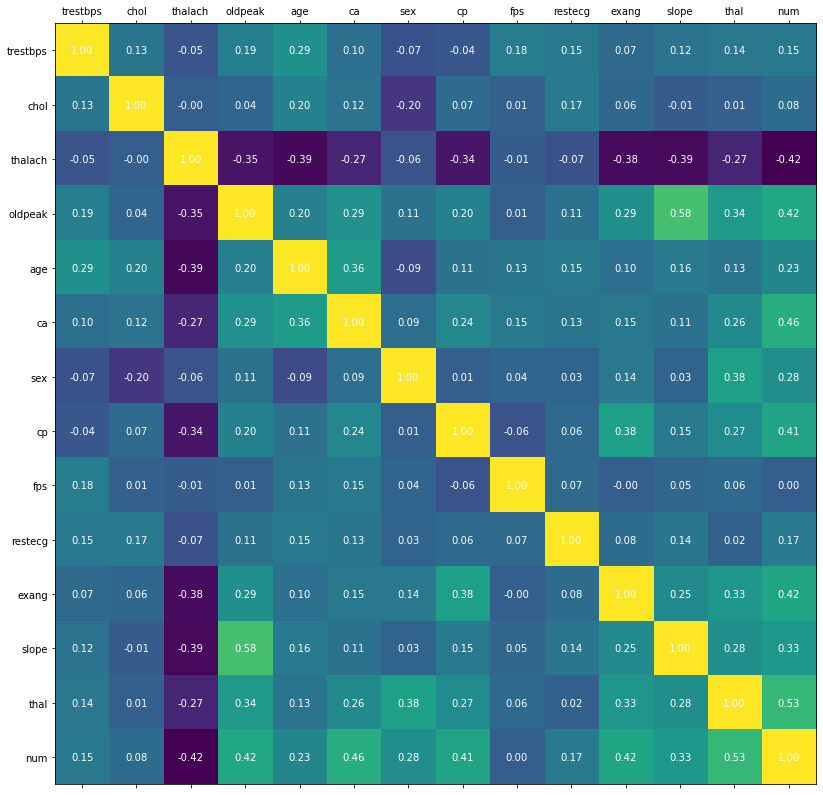

In [ ]:
columns = continuous_vars + discrete_vars + categorical_vars + ['num']
corr_matrix = heart_data[columns].corr()

fig, ax = plt.subplots(figsize=(18, 14))
ax.matshow(corr_matrix)
for (i, j), z in np.ndenumerate(corr_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='w')
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns);

In [ ]:
corr_num = corr_matrix['num'].sort_values(key=abs, ascending=False)
corr_num

num         1.000000
thal        0.526640
ca          0.463189
oldpeak     0.424052
thalach    -0.423817
exang       0.421355
cp          0.408945
slope       0.333049
sex         0.278467
age         0.227075
restecg     0.166343
trestbps    0.153490
chol        0.080285
fps         0.003167
Name: num, dtype: float64

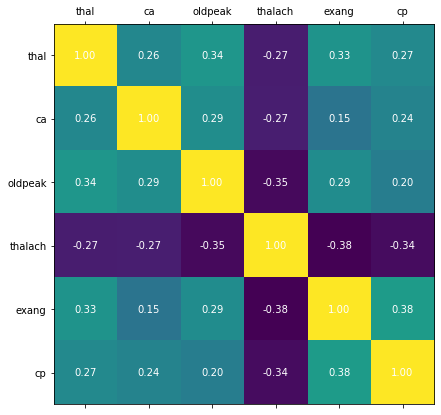

In [ ]:
columns = corr_num.index[1:7].tolist()
corr_matrix = heart_data[columns].corr()

fig, ax = plt.subplots(figsize=(8, 7))
ax.matshow(corr_matrix)
for (i, j), z in np.ndenumerate(corr_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='w')

ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns);

- thalach - ~~exang~~ (korelacja -0.38)
- ~~cp~~ - exang (korelacja 0.38)

#### Wybrane cechy

- thal
- ca
- oldpeak
- thalach

## Ocena 5

#### Podział na zbiory

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(heart_data.iloc[:, :-1], heart_data.iloc[:, -1], test_size=.2, random_state=seed)

test_y = test_y.values
train_y = train_y.values

#### Klasyfikatory wykorzystujące wszystkie cechy

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

vars_standarize = ['trestbps', 'chol', 'thalach', 'age']
vars_normalize = ['oldpeak', 'ca', 'slope', 'sex', 'fps', 'exang', 'cp', 'restecg', 'thal']

transform_pipe = ColumnTransformer([
        ("std", StandardScaler(), vars_standarize),
        ("norm", MinMaxScaler(), vars_normalize),
    ])

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

scikit_model_1 = Pipeline(steps=[
    ('transform', transform_pipe),
    ('class', RidgeClassifier())
])

custom_model_1 = Pipeline(steps=[
    ('transform', transform_pipe),
    ('class', CustomRidgeClassifier())
])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    "class__alpha": np.linspace(0, 30, 200),
}

search = GridSearchCV(custom_model_1, param_grid, n_jobs=4)
search.fit(train_x, train_y)
custom_estimator_1 = search.best_estimator_
print('Best alpha (custom):', search.best_params_['class__alpha'])

search = GridSearchCV(scikit_model_1, param_grid, n_jobs=4)
search.fit(train_x, train_y)
scikit_estimator_1 = search.best_estimator_
print('Best alpha (scikit):', search.best_params_['class__alpha'])

Best alpha (custom): 7.236180904522612
Best alpha (scikit): 6.331658291457286


#### Krzywa ROC

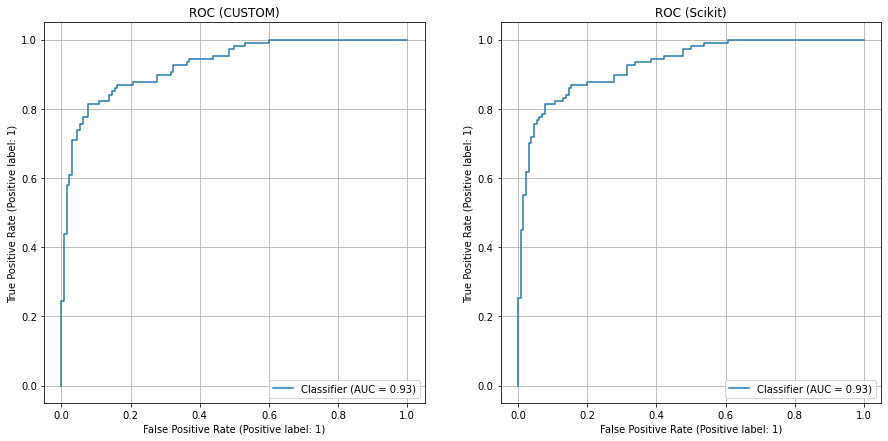

In [ ]:
from sklearn.metrics import RocCurveDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_estimator_1.decision_function(train_x)
predictions_s = scikit_estimator_1.decision_function(train_x)

RocCurveDisplay.from_predictions(train_y, predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(train_y, predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

#### Macierz przekłamań

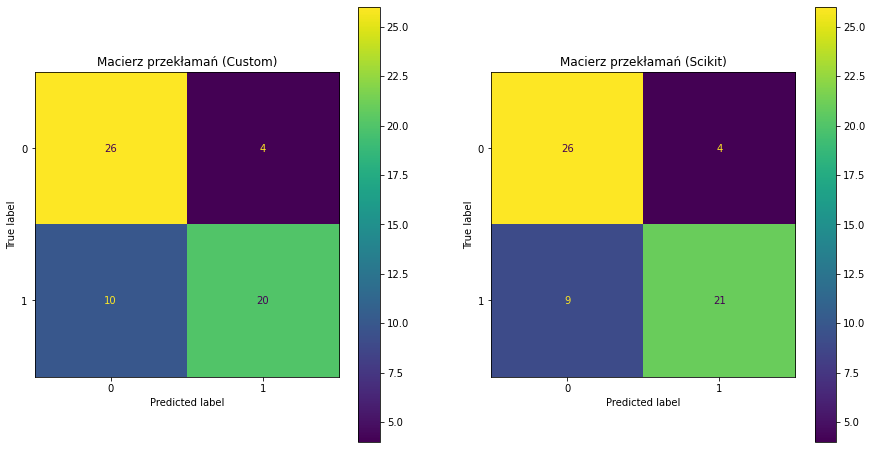

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

custom_pred = custom_estimator_1.predict(test_x)
scikit_pred = scikit_estimator_1.predict(test_x)

ConfusionMatrixDisplay.from_predictions(test_y, custom_pred, ax=ax_c)
ConfusionMatrixDisplay.from_predictions(test_y, scikit_pred, ax=ax_s)

ax_c.set_title('Macierz przekłamań (Custom)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [ ]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk

sens_list = []
spec_list = []
f1_list = []

for model in [custom_estimator_1, scikit_estimator_1]:
    
    predictions = model.predict(test_x)

    sens = recall_score(test_y, predictions)
    spec = recall_score(test_y, predictions, pos_label=0)
    f1 = f1_score(test_y, predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)
    
# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity,F1
Custom,0.666667,0.866667,0.740741
Scikit,0.700000,0.866667,0.763636


#### Czasy

In [ ]:
# Pomiar czasów
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

custom_model_time = clone(custom_estimator_1)
scikit_model_time = clone(scikit_estimator_1)

def time_custom_fit():
    custom_model_time.fit(train_x, train_y)

def time_custom_predict():
    custom_model_time.predict(test_x)

def time_scikit_fit():
    scikit_model_time.fit(train_x, train_y)

def time_scikit_predict():
    scikit_model_time.predict(test_x)


time_cf = timeit.timeit(time_custom_fit, number=100) / 100
time_cp = timeit.timeit(time_custom_predict, number=100) / 100
time_sf = timeit.timeit(time_scikit_fit, number=100) / 100
time_sp = timeit.timeit(time_scikit_predict, number=100) / 100

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,0.004668,0.002609
Scikit,0.005705,0.002655


#### Wybór 4 najlepszych cech

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector

classifier = RidgeClassifier(alpha=1.2)
selector = SequentialFeatureSelector(classifier, n_features_to_select=4)
selector.fit(train_x, train_y)
train_x.columns[selector.get_support()].tolist()

['sex', 'cp', 'thalach', 'ca']

sklearn wybrał sex i cp zamiast thal i oldpeak

#### Klasyfikatory wykorzystujące 4 cechy

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

scikit_features_transform_pipe = ColumnTransformer([
    ("std", StandardScaler(), ['thalach']),
    ("norm", MinMaxScaler(), ['ca', 'sex', 'cp']),
])

custom_features_transform_pipe = ColumnTransformer([
    ("std", StandardScaler(), ['thalach']),
    ("norm", MinMaxScaler(), ['oldpeak', 'ca', 'thal']),
])

custom_model_2 = Pipeline(steps=[
    ('transform', custom_features_transform_pipe),
    ('class', CustomRidgeClassifier())
])

scikit_model_2 = Pipeline(steps=[
    ('transform', scikit_features_transform_pipe),
    ('class', RidgeClassifier())
])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    "class__alpha": np.linspace(0, 30, 200),
}

search = GridSearchCV(custom_model_2, param_grid, n_jobs=4)
search.fit(train_x, train_y)
custom_estimator_2 = search.best_estimator_
print('Best alpha (custom):', search.best_params_['class__alpha'])

search = GridSearchCV(scikit_model_2, param_grid, n_jobs=4)
search.fit(train_x, train_y)
scikit_estimator_2 = search.best_estimator_
print('Best alpha (scikit):', search.best_params_['class__alpha'])

Best alpha (custom): 26.984924623115575
Best alpha (scikit): 0.0


#### Krzywa ROC

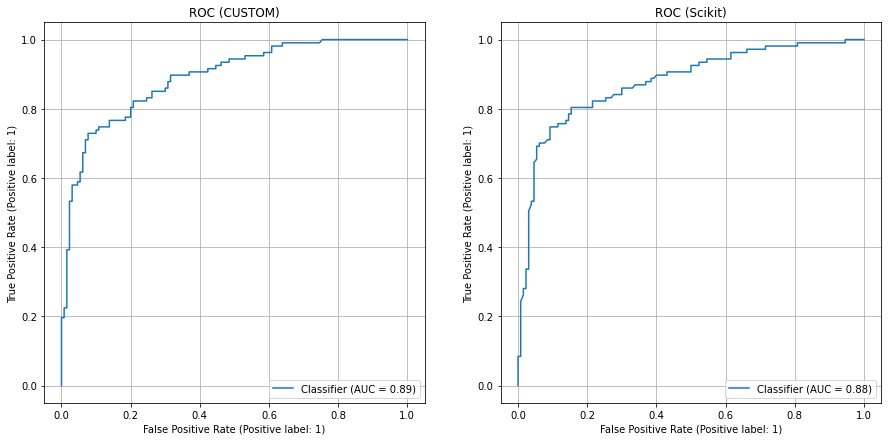

In [ ]:
from sklearn.metrics import RocCurveDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_estimator_2.decision_function(train_x)
predictions_s = scikit_estimator_2.decision_function(train_x)

RocCurveDisplay.from_predictions(train_y, predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(train_y, predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

#### Macierz przekłamań

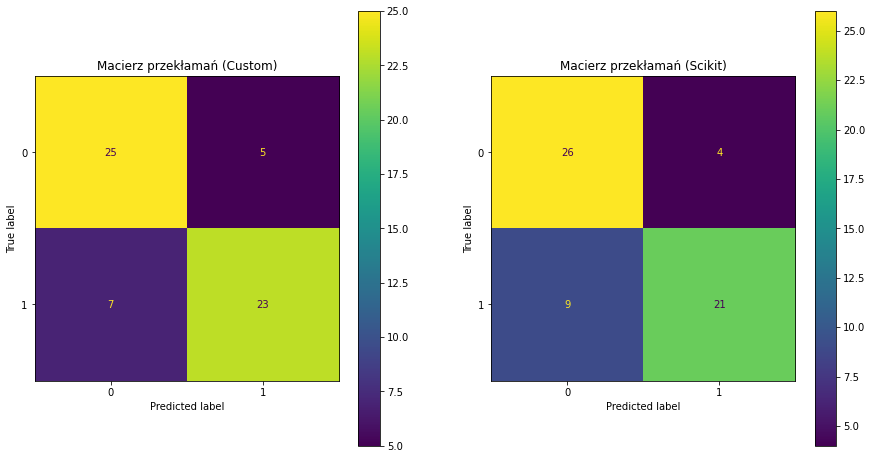

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

custom_pred = custom_estimator_2.predict(test_x)
scikit_pred = scikit_estimator_2.predict(test_x)

ConfusionMatrixDisplay.from_predictions(test_y, custom_pred, ax=ax_c)
ConfusionMatrixDisplay.from_predictions(test_y, scikit_pred, ax=ax_s)

ax_c.set_title('Macierz przekłamań (Custom)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [ ]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk

sens_list = []
spec_list = []
f1_list = []

for model in [custom_estimator_2, scikit_estimator_2]:
    
    predictions = model.predict(test_x)

    sens = recall_score(test_y, predictions)
    spec = recall_score(test_y, predictions, pos_label=0)
    f1 = f1_score(test_y, predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)
    
# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity,F1
Custom,0.766667,0.833333,0.793103
Scikit,0.700000,0.866667,0.763636


#### Czasy

In [ ]:
# Pomiar czasów
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

custom_model_time = clone(custom_estimator_2)
scikit_model_time = clone(scikit_estimator_2)

def time_custom_fit():
    custom_model_time.fit(train_x, train_y)

def time_custom_predict():
    custom_model_time.predict(test_x)

def time_scikit_fit():
    scikit_model_time.fit(train_x, train_y)

def time_scikit_predict():
    scikit_model_time.predict(test_x)


time_cf = timeit.timeit(time_custom_fit, number=100) / 100
time_cp = timeit.timeit(time_custom_predict, number=100) / 100
time_sf = timeit.timeit(time_scikit_fit, number=100) / 100
time_sp = timeit.timeit(time_scikit_predict, number=100) / 100

time_df = pd.DataFrame({'Nauka': [time_cf, time_sf], 'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Nauka,Przewidywanie
Custom,0.004298,0.002555
Scikit,0.005550,0.002614
